Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [1]:
import pandas as pd
import ast
import torch
import torch.nn as nn
import transformers
from transformers import pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
import time
from huggingface_hub import login
import google.generativeai as genai
import os
from tqdm import tqdm
from datasets import Dataset
import json
from openai import OpenAI
import numpy as np
from sklearn.metrics import f1_score
import random

# huggingface API key
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')
login(token=hf_api_key)

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

load_dotenv()

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\caboo\.cache\huggingface\token
Login successful
Device in use: NVIDIA GeForce RTX 3080 Laptop GPU


True

# Reading in data

In [2]:
df = pd.DataFrame()

###   SMALL DATASET   ###
# df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
# print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

###   VALIDATION DATASET   ###
df = pd.read_csv('data/labeled_data_2.csv')
print(df.head())

print(df.shape)


                                                text        timestamp  \
0     Expensive eh now that Uglyfoods closed down :(   30/1/2023 1:04   
1                How dare you.. wan go lim kopi ah??   4/5/2022 18:57   
2  Yeah the governments can politick all they wan...  28/6/2022 13:44   
3               Hijacks event, then complains. Wild.   12/7/2022 7:29   
4  Hate to break it to you. But once someone accu...   23/8/2023 2:08   

              username                                               link  \
0      MangoDangoLango  /r/singapore/comments/10nqt5h/rsingapore_rando...   
1               900122  /r/SingaporeRaw/comments/ui0rmg/dont_take_offe...   
2  DisillusionedSinkie  /r/singapore/comments/vmb197/malaysias_top_tal...   
3            nehjipain  /r/singapore/comments/vx42x1/nus_student_tried...   
4          KeenStudent  /r/singapore/comments/15ybdme/sorry_doesnt_cut...   

      link_id   parent_id       id subreddit_id  \
0  t3_10nqt5h  t1_j6dwxo8  j6fuv4x     t5_2qh8c

# Cleaning

In [3]:
# df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# moderation_dicts = df['moderation']
# moderation_normalized = pd.json_normalize(moderation_dicts)
# # print(moderation_normalized)
# df = df.reset_index(drop=True)
# moderation_normalized = moderation_normalized.reset_index(drop=True)
# df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
# print(df_normalized.columns)
df_normalized = df

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
### removing deleted or removed text ###

### stop word removal ###
# stop_words = set(stopwords.words('english'))

# def remove_stop_words(text):
#     if isinstance(text, str):  # Check if the text is a string
#         return ' '.join([word for word in text.split() if word.lower() not in stop_words])
#     return text 

# df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
# print(df_normalized['text'])
# print(stop_words)
### stop word removal ###

In [4]:
print(df_normalized['username'].value_counts())
print(df_normalized.columns)

username
[deleted]             9
laglory               4
wakkawakkaaaa         3
MAMBAMENTALITY8-24    3
equanimitynow         2
                     ..
EaeleButEeelier       1
Mamakling94           1
redberryboy123        1
ABootSG               1
bueytahanliao         1
Name: count, Length: 273, dtype: int64
Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'moderation', 'toxic', 'hateful'],
      dtype='object')


C:\Users\caboo\AppData\Local\Temp\ipykernel_15728\628181459.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


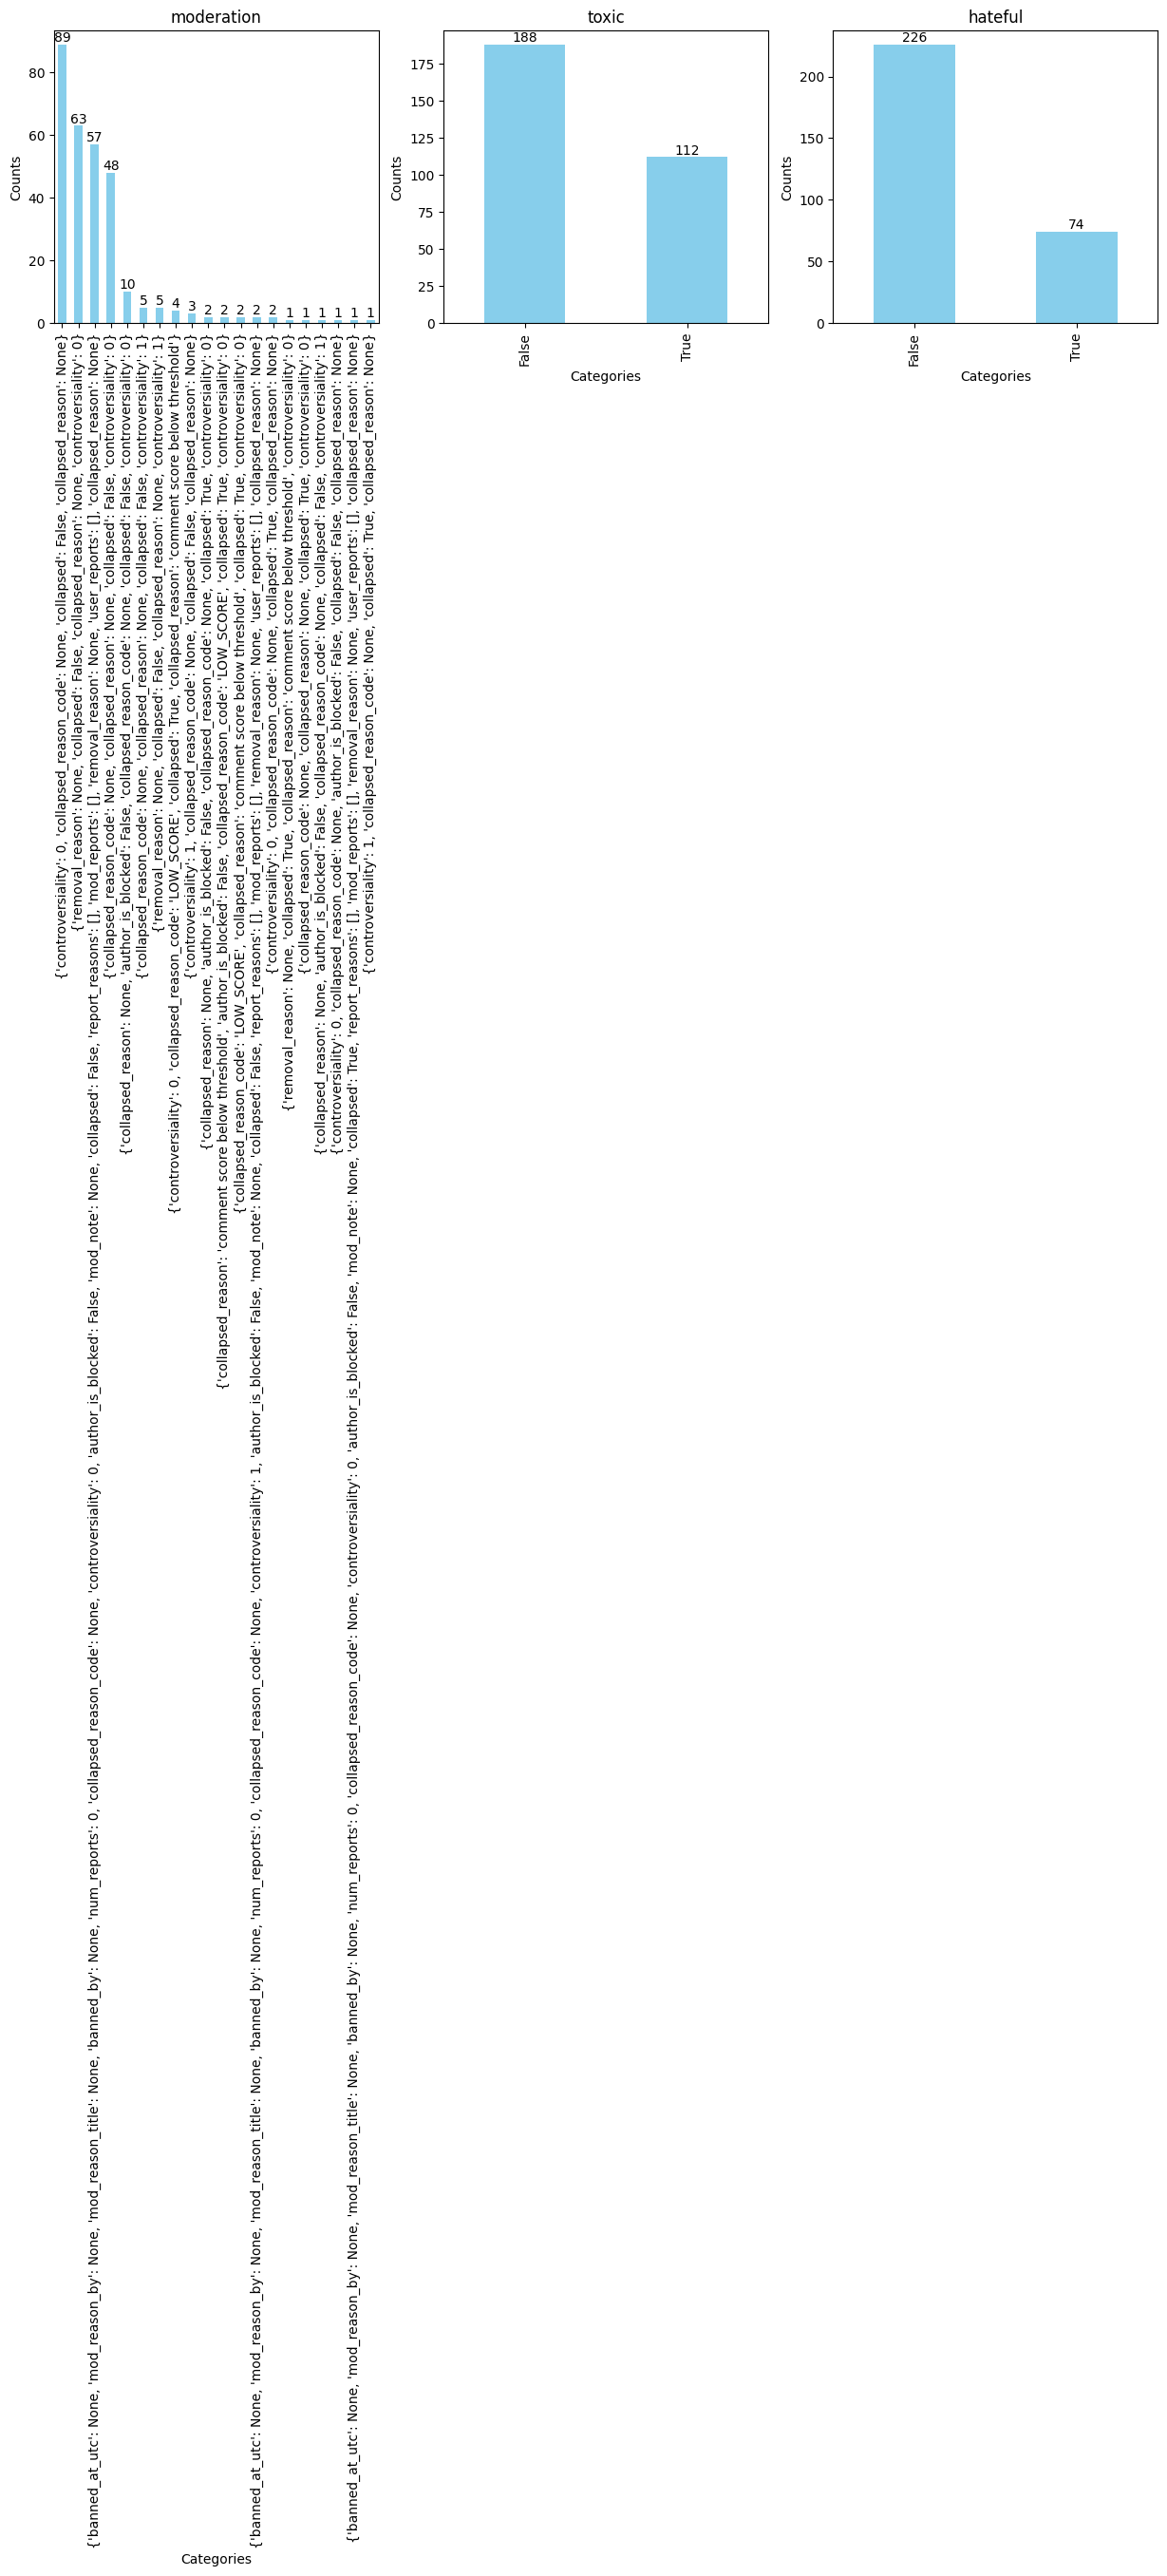

In [5]:
df_for_plot = df_normalized.copy()
df_for_plot.fillna('Not specified', inplace=True)


exclude_columns = [
    'text', 
    'timestamp', 
    'username', 
    'link', 
    'link_id', 
    'parent_id', 
    'id', 
    'subreddit_id'
]
columns_to_plot = [col for col in df_normalized.columns if col not in exclude_columns]


num_columns = len(columns_to_plot)
cols = 3  
rows = (num_columns + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df_for_plot[column].value_counts()
    if not counts.empty:
        bars = counts.plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')

        for bar in bars.patches:
            axes[i].annotate(format(int(bar.get_height())), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

# 2 Using LLMs to label our data (Huggingface)

In [9]:
toxic_classifier = pipeline("text-classification", model="unitary/toxic-bert", return_all_scores=True, device=device)
df_normalized['BERT_toxic'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    try:
        toxic_prediction = toxic_classifier(text)
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del toxic_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_toxic'].value_counts())
toxic_samples = df_normalized[df_normalized['BERT_toxic'] == 1].sample(n=5, random_state=42) 
non_toxic_samples = df_normalized[df_normalized['BERT_toxic'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 Toxic Samples:")
    print(toxic_samples['text'])

    print("\n5 Non-Toxic Samples:")
    print(non_toxic_samples['text'])

f1 = f1_score(df_normalized['toxic'], df_normalized['BERT_toxic'], average='weighted')
print(f"F1 Score: {f1}")

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying toxicity:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Classifying toxicity: 100%|██████████| 300/300 [00:04<00:00, 61.87it/s]

BERT_toxic
False    242
True      58
Name: count, dtype: int64
5 Toxic Samples:
1                                                                                                                                                          How dare you.. wan go lim kopi ah??
29                                                                                                                                          Because only the opinions of the rich count. Moron
173                                                                                                                    Shit now I’m thinking I should pursue my boss’ idea to move me overseas
96                                                                                                                                  I DO NOT WANT MASK MANDATE IN 2025. Don’t fucking curse it
237    If you do not qualify for grant then you probably have decent income and/or do not form any family nucleus. So you are not target market for the gran

## 2.2 unhcr/hatespeech-detection

In [10]:
hate_classifier = pipeline("text-classification", model="unhcr/hatespeech-detection", return_all_scores=True, device=device)
df_normalized['BERT_hate'] = True

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hate speech"):
    text = row['text']

    try:
        hate_prediction = hate_classifier(text)
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'Normal' and score < 0.995:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_hate'] = False
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del hate_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_hate'].value_counts())
hate_samples = df_normalized[df_normalized['BERT_hate'] == 1].sample(n=5, random_state=42) 
non_hate_samples = df_normalized[df_normalized['BERT_hate'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 hate Samples:")
    print(hate_samples['text'])

    print("\n5 Non-hate Samples:")
    print(non_hate_samples['text'])

f1 = f1_score(df_normalized['hateful'], df_normalized['BERT_hate'], average='weighted')
print(f"F1 Score: {f1}")

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying hate speech:  44%|████▍     | 132/300 [00:02<00:02, 62.81it/s]

Error processing toxicity at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying hate speech: 100%|██████████| 300/300 [00:05<00:00, 59.36it/s]

BERT_hate
False    205
True      95
Name: count, dtype: int64
5 hate Samples:
167    It’s obviously not worth more redistribution of wealth to have more Singaporean babies then. That’s the consensus you share with the powers that be. The morality behind it is superfluous; blyat!\n\n1 child care teacher making 4K/ month can herd a class of 20 kids. If each mother averages 2 kids, that’s 10 mothers’ worth of income that teacher frees up. Some who earn a lot more than 4K/ month.
50                                                                                                                                                                                                                                                                                                                              Warms the heart following pics of Uncle in Bugis market, exploiting the situation.
185                                                                                                                 

## 2.3 textdetox/xlmr-large-toxicity-classifier
https://huggingface.co/textdetox/xlmr-large-toxicity-classifier

In [11]:
toxic_classifier = pipeline("text-classification", model="textdetox/xlmr-large-toxicity-classifier", return_all_scores=True, device=device)
df_normalized['BERT_2_toxic'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    try:
        toxic_prediction = toxic_classifier(text)
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_2_toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del toxic_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_2_toxic'].value_counts())
toxic_samples = df_normalized[df_normalized['BERT_2_toxic'] == 1].sample(n=5, random_state=42) 
non_toxic_samples = df_normalized[df_normalized['BERT_2_toxic'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 Toxic Samples:")
    print(toxic_samples['text'])

    print("\n5 Non-Toxic Samples:")
    print(non_toxic_samples['text'])

f1 = f1_score(df_normalized['toxic'], df_normalized['BERT_2_toxic'], average='weighted')
print(f"F1 Score: {f1}")

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying toxicity:  43%|████▎     | 128/300 [00:02<00:02, 66.77it/s]

Error processing toxicity at index 121: The expanded size of the tensor (547) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 547].  Tensor sizes: [1, 514]


Classifying toxicity: 100%|██████████| 300/300 [00:05<00:00, 58.72it/s]


BERT_2_toxic
False    221
True      79
Name: count, dtype: int64
5 Toxic Samples:
136                                                                                                                                                                                                                                                                 Such childish entitlement. No public toilet when you need to go, so you shit on the pavement? No dustbin around, so you litter? \n\nThese adults got up and CHOSE to cycle in the middle of a major road. Non-essential hobbyist activity that impedes usage by the intended users.
4      Hate to break it to you. But once someone accuses you of phototaking them, whether illicit or not, or whether she had nefarious reasons or not. The police here have probable cause to detain you legally.\n\nThe police can check your phones but only if they suspect that you have done anything illegal, or if you're being investigated\n\nKeyword here is suspect. That alone is 

## 2.4 sileod/deberta-v3-base-tasksource-toxicity (hate detection)
https://huggingface.co/sileod/deberta-v3-base-tasksource-toxicity

In [12]:
hate_classifier = pipeline("text-classification", model="sileod/deberta-v3-base-tasksource-toxicity", return_all_scores=True, device=device)
df_normalized['BERT_2_hate'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hate speech"):
    text = row['text']

    try:
        hate_prediction = hate_classifier(text)
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_2_hate'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del hate_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_2_hate'].value_counts())
hate_samples = df_normalized[df_normalized['BERT_2_hate'] == 1].sample(n=5, random_state=42) 
non_hate_samples = df_normalized[df_normalized['BERT_2_hate'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 hate Samples:")
    print(hate_samples['text'])

    print("\n5 Non-hate Samples:")
    print(non_hate_samples['text'])

f1 = f1_score(df_normalized['hateful'], df_normalized['BERT_2_hate'], average='weighted')
print(f"F1 Score: {f1}")

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying hate speech: 100%|██████████| 300/300 [00:12<00:00, 23.26it/s]

BERT_2_hate
False    255
True      45
Name: count, dtype: int64
5 hate Samples:
258    Jamus still not bad. CSJ after all these years still havent learn to control. fking horrible.
182                                                     Laugh ass off first then scold then break up
184                                   so why the fuck are we going back to the office to begin with?
282                                                  Denise Phua and Lim Tean carried her heavy ass.
223                                                            Shitmugam. Sucks to be you right now.
Name: text, dtype: object

5 Non-hate Samples:
226    Joke's on him, Dr M's political party is in shambles and no one really cares about the Singapore-Malaysia rivalry anymore. This old dog's tricks have long lost its relevance.
6                                                                                                                                   I am just baffled that he does not see the irony.
89  

In [13]:
print(df_normalized['hateful'].value_counts())
print(df_normalized['BERT_hate'].value_counts())
print(df_normalized['BERT_2_hate'].value_counts())

print('\n')

print(df_normalized['toxic'].value_counts())
print(df_normalized['BERT_toxic'].value_counts())
print(df_normalized['BERT_2_toxic'].value_counts())

print(f1_score(df_normalized['BERT_hate'], df_normalized['BERT_2_hate'], average='weighted'))


hateful
False    226
True      74
Name: count, dtype: int64
BERT_hate
False    205
True      95
Name: count, dtype: int64
BERT_2_hate
False    255
True      45
Name: count, dtype: int64


toxic
False    188
True     112
Name: count, dtype: int64
BERT_toxic
False    242
True      58
Name: count, dtype: int64
BERT_2_toxic
False    221
True      79
Name: count, dtype: int64
0.4828571428571429


In [23]:

hate_classifier = pipeline("text-classification", model="facebook/roberta-hate-speech-dynabench-r4-target", return_all_scores=True, device=device)
df_normalized['BERT_2_hate'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hate speech"):
    text = row['text']

    try:
        hate_prediction = hate_classifier(text)
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'hate' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_2_hate'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del hate_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_2_hate'].value_counts())
# hate_samples = df_normalized[df_normalized['BERT_2_hate'] == 1].sample(n=5, random_state=42) 
# non_hate_samples = df_normalized[df_normalized['BERT_2_hate'] == 0].sample(n=5, random_state=42)

# with pd.option_context('display.max_colwidth', None):
#     print("5 hate Samples:")
#     print(hate_samples['text'])

#     print("\n5 Non-hate Samples:")
#     print(non_hate_samples['text'])

f1 = f1_score(df_normalized['BERT_3_toxic'], df_normalized['BERT_2_hate'], average='weighted')
print(f"F1 Score: {f1}")


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying hate speech:  65%|██████▌   | 130/200 [00:01<00:00, 75.04it/s]

Error processing toxicity at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying hate speech: 100%|██████████| 200/200 [00:02<00:00, 73.47it/s]

BERT_2_hate
False    172
True      28
Name: count, dtype: int64
F1 Score: 0.9172237196765498


In [21]:
toxic_classifier = pipeline("text-classification", model="cointegrated/rubert-tiny-toxicity", return_all_scores=True, device=device)
df_normalized['BERT_3_toxic'] = True

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    try:
        toxic_prediction = toxic_classifier(text)
        for pred in hate_prediction[0]:
            # import pdb; pdb.set_trace()
            label = pred['label']
            score = pred['score']
            if label == 'non-toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_3_toxic'] = False
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del toxic_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_3_toxic'].value_counts())
# toxic_samples = df_normalized[df_normalized['BERT_2_toxic'] == 1].sample(n=5, random_state=42) 
# non_toxic_samples = df_normalized[df_normalized['BERT_2_toxic'] == 0].sample(n=5, random_state=42)

# with pd.option_context('display.max_colwidth', None):
#     print("5 Toxic Samples:")
#     print(toxic_samples['text'])

#     print("\n5 Non-Toxic Samples:")
#     print(non_toxic_samples['text'])


f1 = f1_score(df_normalized['toxic'], df_normalized['BERT_3_toxic'], average='weighted')
print(f"F1 Score: {f1}")


c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying toxicity:  71%|███████   | 142/200 [00:00<00:00, 173.29it/s]

Error processing toxicity at index 121: The size of tensor a (553) must match the size of tensor b (512) at non-singleton dimension 1


Classifying toxicity: 100%|██████████| 200/200 [00:01<00:00, 173.73it/s]

BERT_3_toxic
False    199
True       1
Name: count, dtype: int64
F1 Score: 0.4797165153686893


# 3 using llms to label our 100k data.

## meta-llama/Llama-3.2-3B-Instruct

### loading the model

In [15]:
pipe = pipeline("text-generation", model='meta-llama/Llama-3.2-3B-Instruct', device=device)

{'error': 'The model meta-llama/Llama-3.1-405B-Instruct is too large to be loaded automatically (811GB > 10GB). Please use Spaces (https://huggingface.co/spaces) or Inference Endpoints (https://huggingface.co/inference-endpoints).'}


In [14]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on a social media platform. You are reviewing a user's comment to determine if it is toxic. Please respond with only False (not toxic) or True (very toxic) for the following comment."},
        {"role": "user", "content": f"how toxic is this text: {text}"},
    ]
    response = toxic_classifier(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_toxic'] = (response[0]['generated_text'][2]['content'] == 'True')

df_normalized['Llama_toxic'] = df_normalized['Llama_toxic'].astype(bool)

Classifying toxicity:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Classifying toxicity:   0%|          | 1/300 [00:12<1:04:15, 12.90s/it]c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601:

In [ ]:
for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hatefulness"):
    text = row['text']
    messages = [
        {"role": "system", "content": "You are a moderator on a social media platform. You are reviewing a user's comment to determine if it is hateful. Please respond with only False (not hateful) or True (very hateful) for the following comment."},
        {"role": "user", "content": f"how hate is this text: {text}"},
    ]
    response = toxic_classifier(messages, max_new_tokens=50, do_sample=False, truncation=True)
    df_normalized.at[index, 'Llama_hate'] = (response[0]['generated_text'][2]['content'] == 'True')

In [19]:
print(df_normalized['Llama_toxic'].value_counts())
print(df_normalized['toxic'].value_counts())
f1 = f1_score(df_normalized['toxic'], df_normalized['Llama_toxic'], average='weighted')
print(f"F1 Score: {f1}")

print(df_normalized['Llama_toxic'].value_counts())
print(df_normalized['toxic'].value_counts())
f1 = f1_score(df_normalized['toxic'], df_normalized['Llama_toxic'], average='weighted')
print(f"F1 Score: {f1}")

Llama_toxic
False    220
True      80
Name: count, dtype: int64
toxic
False    188
True     112
Name: count, dtype: int64
F1 Score: 0.645


In [ ]:
del toxic_classifier